# Movie Classification Team 11

# Latent Dirichelt Allocation

### Team Members:
Andrew Lund, Nicholas Morgam, Amay Umradia, Charles Webb

**The purpose of this notebook is for future scope of work:**
1. To explore the dataset with TMDB plot for 1000 movies using Latent Dirichelt Allocation. We will primarily be using the vanila Latent Dirichelt Allocation and initial knowledge of previous modelling techniques. 
2. To visualize the clusters for the unlabelled dataset.
3. The future scope of work would be to hyper-tune LDA technique and use more advanced models similar to LDA

In [2]:
#import libraries and set seaborn styling
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tmdbsimple as tmdb
import requests
import pandas as pd
import time
import numpy as np
from ast import literal_eval
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import models
sns.set_context('talk')
sns.set_style('ticks')

C:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


---
# Load the movie data from /data

We will be using the TMDB plots as our predictor variable throughout this notebook. The idea is to use Latent Dirichelt Allocation on these plots to observe the classification based on common words

In [41]:
movies = pd.read_csv('data/movies.csv')
movies.head(2)

,tmdb_id,imdb_id,tmdb_genres,imdb_genres,binary_tmdb,binary_imdb,tmdb_plot,imdb_plot,popularity,release_date,...,imdb_bow_plot,combined_plots,combined_bow_plots,combined_clean_plot,tmdb_w2v_plot_mean,imdb_w2v_plot_mean,combined_w2v_plot_mean,tmdb_w2v_plot_matrix,imdb_w2v_plot_matrix,combined_w2v_plot_matrix
0,278,tt0111161,"[18, 80]","[80, 18]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",Framed in the 1940s for the double murder of h...,Chronicles the experiences of a formerly succe...,28.527767,1994-09-23,...,"(0, 398)\t0.22753905257\n (0, 759)\t0.21510...",Framed in the 1940s for the double murder of h...,"(0, 1092)\t0.15089615016\n (0, 811)\t0.1508...","[framed, 1940s, double, murder, wife, lover, u...","[0.0141657, 0.0357291, 0.0355669, 0.0669593, 0...","[0.00466357, 0.0901859, -0.0124761, 0.0549854,...","[0.00908005, 0.064875, 0.00985374, 0.0605507, ...","[[-0.0830078, 0.253906, 0.0712891, 0.0151978, ...","[[0.0201416, 0.114746, -0.357422, -0.228516, 0...","[[-0.0830078, 0.253906, 0.0712891, 0.0151978, ..."
1,238,tt0068646,"[18, 80]","[80, 18]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",Spanning the years 1945 to 1955 a chronicle o...,When the aging head of a famous crime family d...,36.965452,1972-03-14,...,"(0, 515)\t0.172597155095\n (0, 938)\t0.2252...",Spanning the years 1945 to 1955 a chronicle o...,"(0, 1773)\t0.104854849055\n (0, 287)\t0.089...","[spanning, years, 1945, 1955, chronicle, ficti...","[-0.0168208, 0.0596698, -0.00681898, 0.0429789...","[-0.0133263, 0.0813482, 0.0357648, 0.0675641, ...","[-0.0148731, 0.0717528, 0.0169162, 0.0566821, ...","[[0.0517578, 0.0250244, -0.122559, 0.196289, 0...","[[-0.074707, 0.498047, -0.0737305, 0.0727539, ...","[[0.0517578, 0.0250244, -0.122559, 0.196289, 0..."


---
**Function for LDA which takes input as movies, number of topics to be classified, N_gram tokens and stop words**

In [525]:
def lda_process(movies,n_comp,feat,n_gram,stop_words):
    movies['post_tmdb_clean_plot'] = movies['tmdb_clean_plot'].apply(lambda x: post_process(x))
    lda = LatentDirichletAllocation(n_components=n_comp, max_iter=50,learning_method='online',learning_offset=100.)
    
    tf = TfidfVectorizer(max_features=feat,max_df=0.9,min_df=0.02,stop_words=stopwords,ngram_range=(1,n_gram),lowercase=True)
    vectorized = tf.fit_transform(movies.post_tmdb_clean_plot)

    lda.fit(vectorized)
    
    def print_top_words(model, feature_names, n_top_words=1000):
        for topic_idx, topic in enumerate(model.components_):
            print("Topic #%d:" % topic_idx)
            print(" ".join([feature_names[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

    #print("Topics in LDA model:")
    tf_feature_names = tf.get_feature_names()
    #print_top_words(lda, tf_feature_names)
    
    v = lda.transform(vectorized)
    v = v * 100
    
    idx = pd.Index(movies.title)
    df = pd.DataFrame(v, index=idx)#, columns=target_genres)
    vals = np.around(df.values,2)
    
    tfidf_vectorizer = TfidfVectorizer(**tf.get_params())
    dtm_tfidf = tfidf_vectorizer.fit_transform(movies.post_tmdb_clean_plot)
    print(dtm_tfidf.shape)
    
    return df,lda,vectorized,tfidf_vectorizer

In [534]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from sklearn.decomposition.online_lda import LatentDirichletAllocation

import matplotlib.pyplot as plt
import seaborn as sns

import pyLDAvis
import pyLDAvis.sklearn

stopwords = stopwords.words('english')
def post_process(list1):
    str1 = ' '.join(list1)
    return str1

df,lda,vectorized,tfidf_vectorizer = lda_process(movies,19,8000,4,stopwords)
cm = sns.light_palette("lightblue", as_cmap=True)
s = df.sample(n=5,random_state=5).style.background_gradient(cmap=cm)
s




(1000, 155)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
title,,,,,,,,,,,,,,,,,,,
This Is England,1.08726,1.08726,1.08726,1.08726,1.08726,1.08726,1.08726,1.08726,1.08726,1.08726,1.08726,1.08726,1.08726,80.4294,1.08726,1.08726,1.08726,1.08726,1.08726
Romeo and Juliet,63.8599,2.00778,2.00778,2.00778,2.00778,2.00778,2.00778,2.00778,2.00778,2.00778,2.00778,2.00778,2.00778,2.00778,2.00778,2.00778,2.00778,2.00778,2.00778
Annie Hall,72.3864,1.53409,1.53409,1.53409,1.53409,1.53409,1.53409,1.53409,1.53409,1.53409,1.53409,1.53409,1.53409,1.53409,1.53409,1.53409,1.53409,1.53409,1.53409
The Green Mile,1.32129,1.32129,1.32129,1.32129,18.2796,1.32129,1.32129,1.32129,1.32129,10.9872,9.2916,1.32129,1.32129,1.32129,18.3757,1.32129,24.5678,1.32129,1.32129
Out of the Past,24.0246,14.696,1.18893,1.18893,1.18893,8.35137,1.18893,1.18893,1.18893,1.18893,1.18893,1.18893,1.18893,1.18893,1.18893,1.18893,1.18893,1.18893,35.0941


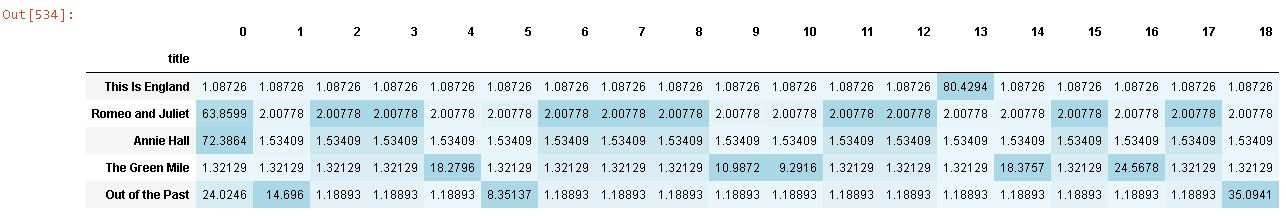

In [590]:
from IPython.display import Image
Image(filename='data/pic1.JPG') 

In [535]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, vectorized, tfidf_vectorizer)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
13     22.443005        1       1 -0.042827 -0.003959
0       9.258647        1       2 -0.154301  0.034665
11      8.068144        1       3 -0.113332 -0.062669
2       6.028718        1       4 -0.049252  0.137528
16      5.387900        1       5  0.097413 -0.048252
8       4.873446        1       6  0.127920  0.096918
6       4.729178        1       7  0.071393 -0.138268
1       4.530512        1       8  0.125642 -0.066754
9       4.473649        1       9  0.022516  0.153805
14      4.278299        1      10 -0.115473  0.191481
18      4.214152        1      11 -0.152691 -0.112957
10      3.760117        1      12 -0.114171 -0.068059
4       3.715413        1      13  0.001135 -0.206452
15      3.621942        1      14  0.032301 -0.010497
17      3.536312        1      15  0.235657  0.044578
7       1.906563        1      16  0.031133 -0.005901
5       1.826260        1      17 -0.027347  0.039736
12      1.795793        1      18  0.016752  0.020746
3       1.551949        1      19  0.007533  0.004311, topic_info=     Category       Freq      Term      Total  loglift  logprob
term                                                           
117   Default  20.000000    secret  20.000000  30.0000  30.0000
101   Default  18.000000     novel  18.000000  29.0000  29.0000
140   Default  34.000000       two  34.000000  28.0000  28.0000
66    Default  18.000000      high  18.000000  27.0000  27.0000
87    Default  33.000000       man  33.000000  26.0000  26.0000
134   Default  22.000000      town  22.000000  25.0000  25.0000
81    Default  14.000000      live  14.000000  24.0000  24.0000
116   Default  17.000000    school  17.000000  23.0000  23.0000
88    Default  15.000000      many  15.000000  22.0000  22.0000
128   Default  16.000000      team  16.000000  21.0000  21.0000
13    Default  19.000000   becomes  19.000000  20.0000  20.0000
46    Default  23.000000      film  23.000000  19.0000  19.0000
125   Default  39.000000     story  39.000000  18.0000  18.0000
141   Default  25.000000       war  25.000000  17.0000  17.0000
131   Default  16.000000     three  16.000000  16.0000  16.0000
27    Default  15.000000     crime  15.000000  15.0000  15.0000
65    Default  23.000000      help  23.000000  14.0000  14.0000
2     Default  22.000000  american  22.000000  13.0000  13.0000
68    Default  13.000000     house  13.000000  12.0000  12.0000
55    Default  14.000000    future  14.000000  11.0000  11.0000
49    Default  19.000000     first  19.000000  10.0000  10.0000
121   Default  15.000000     small  15.000000   9.0000   9.0000
108   Default  13.000000    police  13.000000   8.0000   8.0000
135   Default  14.000000     tries  14.000000   7.0000   7.0000
48    Default  28.000000     finds  28.000000   6.0000   6.0000
102   Default  22.000000       old  22.000000   5.0000   5.0000
89    Default  11.000000       may  11.000000   4.0000   4.0000
28    Default  12.000000      dark  12.000000   3.0000   3.0000
97    Default  18.000000     named  18.000000   2.0000   2.0000
40    Default  13.000000      evil  13.000000   1.0000   1.0000
...       ...        ...       ...        ...      ...      ...
16    Topic19   0.229094      best   9.653226   0.4247  -5.0442
38    Topic19   0.229173    events   9.703634   0.4199  -5.0439
6     Topic19   0.229316  attempts   9.720362   0.4188  -5.0432
115   Topic19   0.229312      save   9.720538   0.4187  -5.0432
18    Topic19   0.229357   british   9.817793   0.4090  -5.0431
124   Topic19   0.229543      stop  10.052746   0.3861  -5.0422
50    Topic19   0.229388    forced  10.022119   0.3885  -5.0429
25    Topic19   0.229305     comes   9.908484   0.3996  -5.0433
145   Topic19   0.229863     woman  17.938573  -0.1916  -5.0408
152   Topic19   0.229691     years  19.944612  -0.2983  -5.0416
24    Topic19   0.229592      city  14.915769  -0.0082  -5.0420
144   T

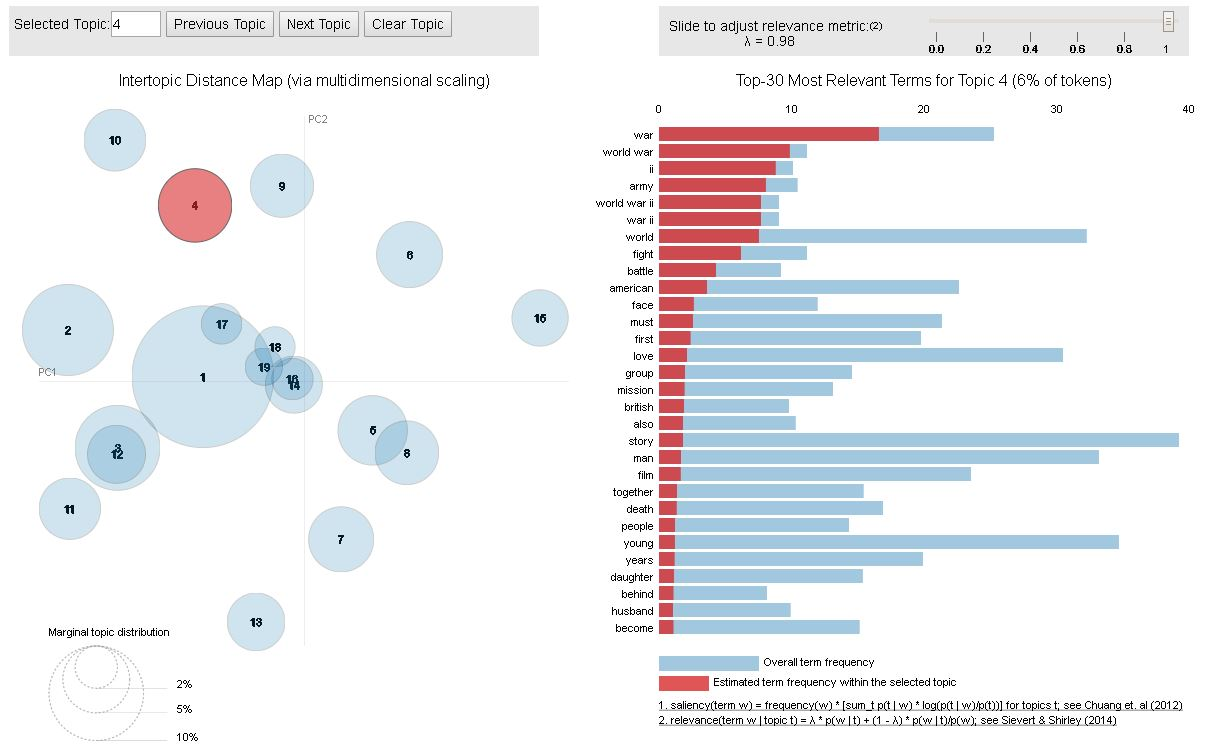

In [591]:
from IPython.display import Image
Image(filename='data/pic2.JPG') 

In [585]:
df,lda,vectorized,tfidf_vectorizer = lda_process(movies,8,8000000,20,stopwords)
cm = sns.light_palette("lightblue", as_cmap=True)
s = df.sample(n=5,random_state=5).style.background_gradient(cmap=cm)
s

(1000, 155)


,0,1,2,3,4,5,6,7
title,,,,,,,,
This Is England,2.58356,10.391,2.59923,2.59416,2.59135,2.58981,2.5914,74.0594
Romeo and Juliet,4.76851,4.78304,4.76879,4.77602,4.77695,66.5736,4.77581,4.77726
Annie Hall,3.64346,3.64556,3.64442,3.64521,3.64602,3.65508,3.64462,74.4756
The Green Mile,3.13926,3.15059,3.14518,3.14159,16.7245,14.697,17.759,38.2429
Out of the Past,2.87275,2.84914,2.8361,80.1038,2.83639,2.83279,2.83426,2.83481


In [586]:
pyLDAvis.enable_notebook()
py_data = pyLDAvis.sklearn.prepare(lda, vectorized, tfidf_vectorizer)
pyLDAvis.display(py_data)